In [1]:
# 1D heat equation
# Import libraries

import numpy as np
# Backend selection (Must place it before importing DeepXDE. Or you can reload the module as well)
import os 
os.environ['DDE_BACKEND']='tensorflow.compat.v1'
import deepxde as dde
import plotly.graph_objects as go

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.



Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# PDE form
# We can use sympy library to check the PDE is correct
import sympy as sy
sy.init_printing(use_latex='mathjax')
u, x, t = sy.symbols('u,x,t')
u = sy.Function('u')(x, t)
pde=sy.Eq(sy.diff(u,t),sy.diff(u,x,x))
pde


                2         
∂              ∂          
──(u(x, t)) = ───(u(x, t))
∂t              2         
              ∂x          

In [3]:
#Case Background
def pde(x,u):   # The x here indicating inputs that contain x and t. Therefore, the gradient definition will require a list number. 
                # For example, when we assume x is a list of [x,t], then du/dt wil require u and x[:,1]
    dudx=dde.grad.hessian(u,x,i=0,j=0)      # Hessian gives second-order differential
    dudt=dde.grad.jacobian(u,x,i=0,j=1)     # Jacobian gives first-order differential
    return dudt-dudx   # In residual form                 

def func(x):    # Condition function
    return np.sin(np.pi*x[:,0:1])

# Define geometry domain
# 1D case
geom=dde.geometry.Interval(0,1)
# Define time doamin
timedomain=dde.geometry.TimeDomain(0,1)
# Compile both to form geo-time data
geotim=dde.geometry.GeometryXTime(geom,timedomain)
# Define initial condition 
# The arguments indicates on where it applies what constraints at what variable that is at initial condition (t=0). 
# For example, the line below explains: at the defined geotime domain, appy the defiend function on all variables (lambda_) when they are at time 0. 
ic=dde.IC(geotim, func , lambda _, on_initial: on_initial)

Compiling model...
Building feed-forward neural network...
'build' took 0.050021 s




'compile' took 0.594095 s

Training model...

Step      Train loss              Test loss               Test metric
0         [1.24e-02, 9.45e-01]    [1.24e-02, 9.45e-01]    []  
1000      [7.59e-04, 6.33e-04]    [7.59e-04, 6.33e-04]    []  
2000      [1.81e-04, 3.03e-04]    [1.81e-04, 3.03e-04]    []  
3000      [8.85e-05, 2.71e-04]    [8.85e-05, 2.71e-04]    []  
4000      [1.30e-03, 3.78e-04]    [1.30e-03, 3.78e-04]    []  
5000      [3.43e-05, 2.31e-04]    [3.43e-05, 2.31e-04]    []  
6000      [2.90e-05, 2.24e-04]    [2.90e-05, 2.24e-04]    []  
7000      [1.84e-05, 2.14e-04]    [1.84e-05, 2.14e-04]    []  
8000      [1.66e-04, 2.15e-04]    [1.66e-04, 2.15e-04]    []  
9000      [1.60e-05, 2.13e-04]    [1.60e-05, 2.13e-04]    []  
10000     [1.46e-05, 2.06e-04]    [1.46e-05, 2.06e-04]    []  

Best model at step 10000:
  train loss: 2.21e-04
  test loss: 2.21e-04
  test metric: []

'train' took 37.351437 s

Saving loss history to c:\Users\yesda\Desktop\PINN File\PINN Examples\los

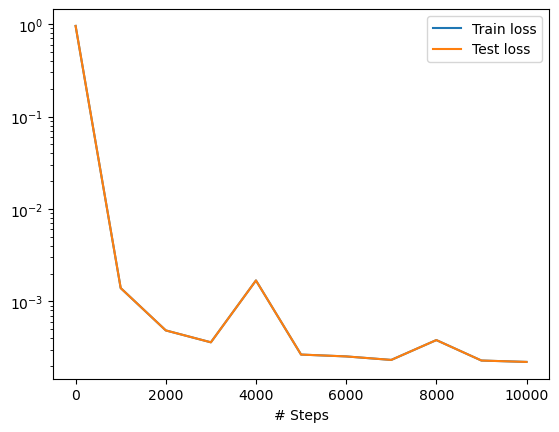

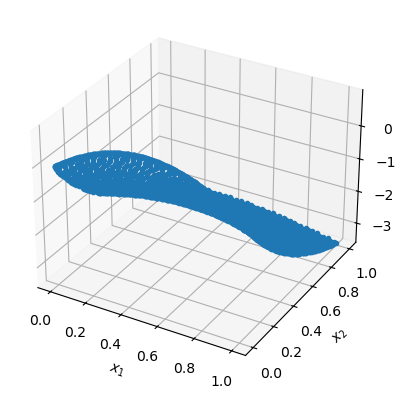

In [4]:
# PINN structure
# Compile all data defiend earlier
data=dde.data.TimePDE(
    geotim,
    pde,
    [ic],
    # As mentioned in the report, DeepXDE PINN calculates loss at residual points.
    # There are four regions in DeepXDE: Boundary (at geometrical boundary), Initial (at time equals 0), Domain (at bullk domain), Test (used on testing after training) 
    # The number of points applies on a specific region will increase the accuracy of that region during training.
    # Its similar to mesh in FEM. More residual points increase accuracy but more inefficient.
    # The distribution of points depends on users and problems. 
    num_domain=2000,    #Residual points at domain 
    num_boundary=200,   #Residual points at boundary
    num_initial=200)    #Residual points at initial 

#Network Structure
#The input layers has 2 for x and t. The output layer has only 1 for u.  
layer=[2]+[32]*3+[1]
net=dde.maps.FNN(layer,"tanh","Glorot uniform")
#Model Compile
model=dde.Model(data,net)
model.compile("adam",lr=0.001)
#Start to train
losshistory,train_state=model.train(iterations=10000)
# Save data and plot result
dde.saveplot(losshistory,train_state,issave=True,isplot=True)


In [5]:
# 3D Plot
# It is hard to see the simulation result from the DeepXDE default output, especially, when there is more than 2 dimensions. 
x=np.linspace(0,1,100)
t=np.linspace(0,1,100)
X,T=np.meshgrid(x,t)
X_flat=X.flatten()[:,None]
T_flat=T.flatten()[:,None]
insert=np.hstack((X_flat, T_flat))
result=model.predict(insert)
U=result.reshape(100,100)

fig=go.Figure(data=[go.Surface(z=U,x=X,y=T, colorscale="Viridis")])
fig.update_layout(title="1D Heat Equation",
                  scene=dict(
                      xaxis_title="x",
                      yaxis_title="t",
                      zaxis_title="u(x,t)"
                  ))
fig.show()

Compiling model...
Building feed-forward neural network...
'build' took 0.081342 s

'compile' took 0.685178 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [5.51e+00]    [5.86e+00]    [4.69e-01]    
1000      [1.38e-03]    [1.93e-03]    [5.69e-03]    
2000      [2.91e-04]    [6.60e-04]    [1.64e-03]    
3000      [1.37e-04]    [3.46e-04]    [1.17e-03]    
4000      [6.31e-05]    [1.71e-04]    [9.10e-04]    
5000      [3.81e-05]    [1.10e-04]    [7.95e-04]    
6000      [3.35e-04]    [4.40e-04]    [3.29e-03]    
7000      [3.81e-04]    [3.86e-04]    [3.40e-03]    
8000      [1.90e-05]    [7.22e-05]    [5.83e-04]    
9000      [3.42e-05]    [8.98e-05]    [2.36e-03]    
10000     [1.46e-05]    [6.14e-05]    [5.06e-04]    

Best model at step 10000:
  train loss: 1.46e-05
  test loss: 6.14e-05
  test metric: [5.06e-04]

'train' took 9.552047 s

Saving loss history to c:\Users\yesda\Desktop\PINN File\PINN Examples\loss.dat ...
Saving training data to c:\

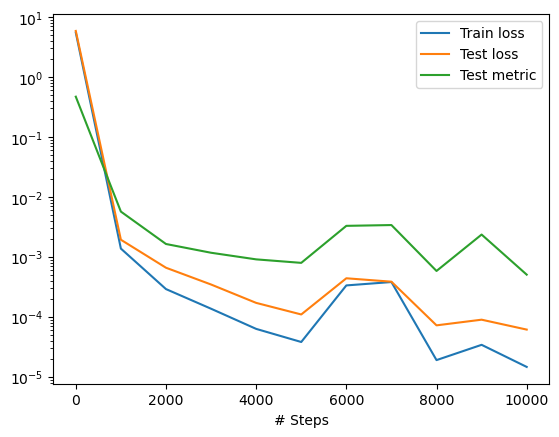

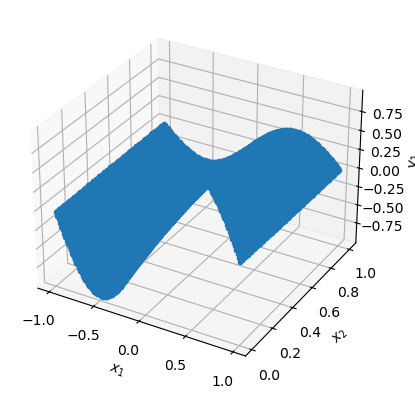

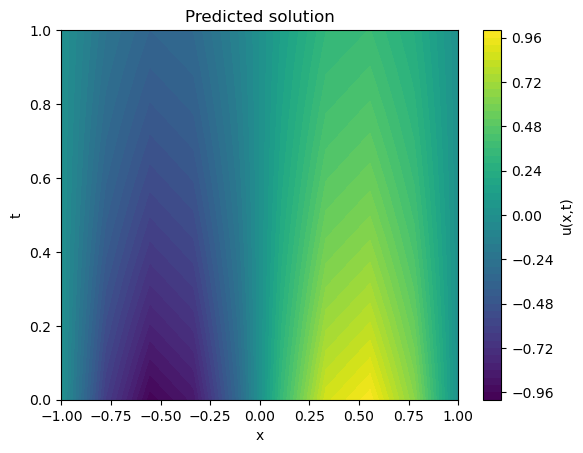

In [6]:
#1D Heat equation with a source and sink term
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle"""
import deepxde as dde
import numpy as np
from deepxde.backend import tf
import matplotlib.pyplot as plt
# Backend pytorch
# import torch
# Backend jax
# import jax.numpy as jnp
# Backend paddle
# import paddle

#PDE Definition
def pde(x, y):
    # Most backends
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    # Backend jax
    # dy_t, _ = dde.grad.jacobian(y, x, i=0, j=1)
    # dy_xx, _ = dde.grad.hessian(y, x, i=0, j=0)
    # Backend tensorflow.compat.v1 or tensorflow
    return (
        dy_t
        - dy_xx
        + tf.exp(-x[:, 1:])
        * (tf.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * tf.sin(np.pi * x[:, 0:1]))
    )
    # Backend pytorch
    # return (
    #     dy_t
    #     - dy_xx
    #     + torch.exp(-x[:, 1:])
    #     * (torch.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * torch.sin(np.pi * x[:, 0:1]))
    # )
    # Backend jax
    # return (
    #     dy_t
    #     - dy_xx
    #     + jnp.exp(-x[:, 1:])
    #     * (jnp.sin(np.pi * x[..., 0:1]) - np.pi ** 2 * jnp.sin(np.pi * x[..., 0:1]))
    # )
    # Backend paddle
    # return (
    #     dy_t
    #     - dy_xx
    #     + paddle.exp(-x[:, 1:])
    #     * (paddle.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * paddle.sin(np.pi * x[:, 0:1]))
    # )

# Define a solution function 
def func(x):
    return np.sin(np.pi * x[:, 0:1]) * np.exp(-x[:, 1:])

# Geometry domain
geom = dde.geometry.Interval(-1, 1)
# Time domain
timedomain = dde.geometry.TimeDomain(0, 1)
# Compile 
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Data compile (without IC and BC)
data = dde.data.TimePDE(geomtime, pde, [], num_domain=40, solution=func, num_test=10000)

# Network structure 
layer_size = [2] + [32] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)
# The netowrk output is mutiplied with the following equation. It is usually used to enforce strong IC or BC. In this case, it can be a boundary or initial condition when x is near 1 or t is 0.  
net.apply_output_transform(
    # Backend tensorflow.compat.v1 or tensorflow
    lambda x, y: x[:, 1:2] * (1 - x[:, 0:1] ** 2) * y + tf.sin(np.pi * x[:, 0:1])
    # Backend pytorch
    # lambda x, y: x[:, 1:2] * (1 - x[:, 0:1] ** 2) * y + torch.sin(np.pi * x[:, 0:1])
    # Backend jax
    # lambda x, y: x[..., 1:2] * (1 - x[..., 0:1] ** 2) * y + jnp.sin(np.pi * x[..., 0:1])
    # Backend paddle
    # lambda x, y: x[:, 1:2] * (1 - x[:, 0:1] ** 2) * y + paddle.sin(np.pi * x[:, 0:1])
)

# Model compile
model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])

# Training 
losshistory, train_state = model.train(iterations=10000)
# Save and plot the result 
dde.saveplot(losshistory,train_state,issave=True,isplot=True)

# Additional plot 
import matplotlib.pyplot as plt
import numpy as np
# Create a grid of points to evaluate the solution
x = np.linspace(-1, 1, 10)
t = np.linspace(0, 1, 10)
X, T = np.meshgrid(x, t)
points = np.vstack([X.ravel(), T.ravel()]).T

# Predict the solution at these grid points
y_pred = model.predict(points).reshape(X.shape)

plt.contourf(X, T, y_pred, levels=50, cmap='viridis')
plt.colorbar(label='u(x,t)')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted solution')
plt.show()